# Analyse Graph Centrality Measures (GCM) on DBpedia data 

In [1]:
# Importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON, N3
#import lxml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
#from networkx import Graph as NXGraph
#from rdflib import Graph as RDFGraph
#from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import statistics
import collections
#import danker # https://github.com/athalhammer/danker
from scipy import stats
from scipy.stats import kstest
# https://www.statology.org/normality-test-python/

from urllib import parse
from sklearn import linear_model
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

import mlnotify 
# https://github.com/aporia-ai/mlnotify
# Use %%notify at beginning of cell

import os.path, time
# Use %%time at beginning of cell

print('------------')
!python --version
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
print("Seaborn " + sns.__version__)
#print("Networkx " + nx.__version__)
print('------------')
print("All packages loaded and ready to roll :-)")

------------
Python 3.7.6
Pandas 1.3.4
Numpy 1.18.1
Seaborn 0.11.2
------------
All packages loaded and ready to roll :-)


In [2]:
# Load GCM data

# NetworkX
#df_nx_gcm = pd.read_csv('../data/gcm_computed.nosync/nx-gcm.csv')

# iGraph
df_ig_gcm = pd.read_csv('../data/gcm_computed.nosync/ig-gcm.csv')

#print(df_gcm.head())
#print('======================')
#print(df_ig_gcm.head())

In [4]:
# Standardize GCMs
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = preprocessing.StandardScaler()

df_ig_gcm_scaled = df_ig_gcm.copy()
df_ig_gcm_scaled[['degree', 'eigenvector', 'pagerank']] = scaler.fit_transform(df_ig_gcm[['degree', 'eigenvector', 'pagerank']])
df_ig_gcm_scaled.head()

,resource,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Billy_Coggins__Car...,-0.005582,1.346159,-0.004504
1,http://dbpedia.org/ontology/CareerStation,2351.421216,2138.166451,2029.349468
2,http://dbpedia.org/resource/News_Patrol__A2Z_N...,0.003101,-0.331647,-0.000453
3,http://dbpedia.org/resource/ZOE_Broadcasting_N...,0.019019,-0.331645,0.011483
4,http://dbpedia.org/resource/Yu_Yongfu,-0.001241,-0.331641,-0.001202


In [5]:
print("Data types:")
print(df_ig_gcm.dtypes)
print('------------------------')
print("Memory usage:")
print(df_ig_gcm.memory_usage(deep=True))
print('------------------------')
print("Dataframe shape is {}".format(df_ig_gcm.shape))

print("========================")

print("Degree Centrality Kurtosis: %s" % stats.kurtosis(df_ig_gcm['degree']))
print("Degree Centrality Skewness: %s" % stats.skew(df_ig_gcm['degree']))
print('------------------------')
print("Eigenvector Centrality Kurtosis: %s" % stats.kurtosis(df_ig_gcm['eigenvector']))
print("Eigenvector Centrality Skewness: %s" % stats.skew(df_ig_gcm['eigenvector']))
print('------------------------')
print("PageRank Kurtosis: %s" % stats.kurtosis(df_ig_gcm['pagerank']))
print("PageRank Skewness: %s" % stats.skew(df_ig_gcm['pagerank']))

Data types:
resource        object
degree           int64
eigenvector    float64
pagerank       float64
dtype: object
------------------------
Memory usage:
Index                128
resource       964958363
degree          65946664
eigenvector     65946664
pagerank        65946664
dtype: int64
------------------------
Dataframe shape is (8243333, 4)
Degree Centrality Kurtosis: 3845700.692636409
Degree Centrality Skewness: 1758.6476950353158
------------------------
Eigenvector Centrality Kurtosis: 2535495.292056733
Eigenvector Centrality Skewness: 1186.2822293812544
------------------------
PageRank Kurtosis: 2865512.8079392132
PageRank Skewness: 1578.3902507400448


In [6]:
df_ig_gcm.describe()

,degree,eigenvector,pagerank
count,8.243333e+06,8.243333e+06,8.243333e+06
mean,6.857220e+00,1.550843e-04,1.213102e-07
std,6.910175e+02,4.676179e-04,1.375352e-05
min,1.000000e+00,0.000000e+00,2.435047e-08
25%,2.000000e+00,1.842308e-11,5.151196e-08
50%,3.000000e+00,2.267567e-09,6.047217e-08
75%,5.000000e+00,8.826938e-08,8.760632e-08
max,1.624880e+06,1.000000e+00,2.791082e-02


In [7]:
# (OLD) Method for splitting the resource to get resource/name (based of the URI) to match PageRank dataframe

def node_path (row):
    return parse.urlsplit(row['resource']).path.split('/', 1)[-1]

In [8]:
# Function for printing a GCMs mean, stdev, as well as the max and min node

def gcmStats(data_frame, gcm_string):
    df_gcm = data_frame.copy()
    gcm_col = gcm_string
    gcm_top = df_gcm.sort_values(by=[gcm_col], ascending=False)
    gcm_low = df_gcm.sort_values(by=[gcm_col])

    print(gcm_col.upper()," CENTRALITY")
    print("==========================")
    print("The mean degree centrality is {}, with stdev {}".format(np.nanmean(df_gcm[gcm_col].values), np.nanstd(df_gcm[gcm_col].values)))#, statistics.stdev(degreesDC)))
    print("The maximum node is {} - with value {}".format(gcm_top['resource'].iat[0], gcm_top[gcm_col].iat[0]))
    print("The minimum node is {} - with value {}".format(gcm_low['resource'].iat[0], gcm_low[gcm_col].iat[0]))

In [9]:
gcmStats(df_ig_gcm, 'degree')

DEGREE  CENTRALITY
The mean degree centrality is 6.857219525160515, with stdev 691.0174712767385
The maximum node is http://dbpedia.org/ontology/CareerStation - with value 1624880
The minimum node is http://dbpedia.org/resource/Robert_Dalrymple_Ross - with value 1


In [10]:
gcmStats(df_ig_gcm, 'eigenvector')

EIGENVECTOR  CENTRALITY
The mean degree centrality is 0.00015508427622203387, with stdev 0.0004676179048092296
The maximum node is http://dbpedia.org/ontology/CareerStation - with value 1.0
The minimum node is http://dbpedia.org/resource/705_Erminia__Beltasteroid-stub__1 - with value 0.0


In [11]:
gcmStats(df_ig_gcm, 'pagerank')

PAGERANK  CENTRALITY
The mean degree centrality is 1.213101545212344e-07, with stdev 1.3753518418526512e-05
The maximum node is http://dbpedia.org/ontology/CareerStation - with value 0.0279108165979626
The minimum node is http://dbpedia.org/resource/Rush_Tower,_Missouri - with value 2.4350470029608183e-08


## Test on normal distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

In [ ]:
print("Normal distribution for Degree Centrality")
print('======================')
print('NetworkX')
print(stats.normaltest(df_nx_gcm['degree']))
print(kstest(df_nx_gcm['degree'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

print('----------------------')
print('iGraph')
print(stats.normaltest(df_ig_gcm['degree']))
print(kstest(df_ig_gcm['degree'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

#Normal distribution for Degree Centrality
#======================
#NetworkX
#NormaltestResult(statistic=69557965.55953461, pvalue=0.0)
#KstestResult(statistic=0.5000000483957555, pvalue=0.0) [Kolmogorov-Smirnov-Test]
#----------------------
#iGraph
#NormaltestResult(statistic=69557965.55953465, pvalue=0.0)
#KstestResult(statistic=0.8413447460685429, pvalue=0.0) [Kolmogorov-Smirnov-Test]

In [ ]:
print("Normal distribution for Eigenvector Centrality")
print('======================')
print('NetworkX')
print("Not computed in NetworkX")

print('----------------------')
print('iGraph')
print(stats.normaltest(df_ig_gcm['eigenvector']))
print(kstest(df_ig_gcm['eigenvector'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

#Normal distribution for Eigenvector Centrality
#======================
#NetworkX
#Not computed in NetworkX
#----------------------
#iGraph
#NormaltestResult(statistic=63653056.418342546, pvalue=0.0)
#KstestResult(statistic=0.5, pvalue=0.0) [Kolmogorov-Smirnov-Test]

In [ ]:
print("Normal distribution for PageRank")
print('======================')
print('NetworkX')
print(stats.normaltest(df_nx_gcm['pagerank']))
print(kstest(df_nx_gcm['pagerank'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

print('----------------------')
print('iGraph')
print(stats.normaltest(df_ig_gcm['pagerank']))
print(kstest(df_ig_gcm['pagerank'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

#Normal distribution for PageRank
#======================
#NetworkX
#NormaltestResult(statistic=68373823.03822671, pvalue=0.0)
#KstestResult(statistic=0.5000000072594243, pvalue=0.0) [Kolmogorov-Smirnov-Test]
#----------------------
#iGraph
#NormaltestResult(statistic=67903070.56349243, pvalue=0.0)
#KstestResult(statistic=0.500000009714432, pvalue=0.0) [Kolmogorov-Smirnov-Test]

## Get DBpedia categories

In [201]:
# Load pre-queried (via queried web-interface) DBpedia categories
# https://dbpedia.org/sparql/

# 90s films from the aggregated Categories: 1990_films, 1991_films, 1992_films, ...
df_film90 = pd.read_csv("../data/sparql_cat_queries/sparql_90film.csv")
df_film90.rename(columns={"90film": "resource"}, inplace=True) #rename column to match PageRank dataframe

# actors from the "Occupation": "Actor"@en
df_actor = pd.read_csv("../data/sparql_cat_queries/sparql_actor.csv")
df_actor.rename(columns={"actor": "resource"}, inplace=True)

# Music Genre from the "Type": "dbo:MusicGenre"
df_musicGenre = pd.read_csv("../data/sparql_cat_queries/sparql_musicGenre.csv")
df_musicGenre.rename(columns={"mGenre": "resource"}, inplace=True)

# Books from the "Type":"dbo:book"
df_book = pd.read_csv("../data/sparql_cat_queries/sparql_book.csv")
df_book.rename(columns={"book": "resource"}, inplace=True)

# Book authors from the "Type": author UNION book dbo:author
df_bookAut = pd.read_csv("../data/sparql_cat_queries/sparql_bookAuthor.csv")
df_bookAut.rename(columns={"author": "resource"}, inplace=True)

# Politicians from the "Type": Person/Politician
df_pol = pd.read_csv("../data/sparql_cat_queries/sparql_politician.csv")
df_pol.rename(columns={"pol": "resource"}, inplace=True)

# POTUS from the "Category": Presidents_of_the_United_States
df_potus = pd.read_csv("../data/sparql_cat_queries/sparql_potus.csv")
df_potus.rename(columns={"potus": "resource"}, inplace=True)

# Cities from the "Category": "dbo:City"
df_city = pd.read_csv("../data/sparql_cat_queries/sparql_city.csv")
df_city.rename(columns={"city": "resource"}, inplace=True)

# Lakes from the "Category": "dbo:Lake"
df_lake = pd.read_csv("../data/sparql_cat_queries/sparql_lake.csv")
df_lake.rename(columns={"lake": "resource"}, inplace=True)

# Mountains from the "Category": "dbo:Mountain"
df_mountain = pd.read_csv("../data/sparql_cat_queries/sparql_mountain.csv")
df_mountain.rename(columns={"mount": "resource"}, inplace=True)

# EU capitals from the "Category": Capitals_in_Europe
df_euCap = pd.read_csv("../data/sparql_cat_queries/sparql_euCap.csv")
df_euCap.rename(columns={"euCap": "resource"}, inplace=True)

# EU countries from the "Category": Countries_in_Europe
df_euCou = pd.read_csv("../data/sparql_cat_queries/sparql_euCountry.csv")
df_euCou.rename(columns={"euCountry": "resource"}, inplace=True)

# Asian countries from the "Category": "dbc:Countries_in_Asia", "dbc:East_Asian_countries" and "dbc:Central_Asian_countries"
df_asCou = pd.read_csv("../data/sparql_cat_queries/sparql_asCountry.csv")
df_asCou.rename(columns={"asCountry": "resource"}, inplace=True)

# Continents from the "Category": "dbo:Continents"
df_continent = pd.read_csv("../data/sparql_cat_queries/sparql_continent.csv")
df_continent.rename(columns={"conti": "resource"}, inplace=True)

# Birds from the "Class": "dbr:Bird"
df_bird = pd.read_csv("../data/sparql_cat_queries/sparql_bird.csv")
df_bird.rename(columns={"bird": "resource"}, inplace=True)

# African animals from the "Category": "dbc:Vertebrates_of_Africa"
df_africanAnimal = pd.read_csv("../data/sparql_cat_queries/sparql_africanAnimal.csv")
df_africanAnimal.rename(columns={"afrAnimal": "resource"}, inplace=True)

# Furniture from the "Category": "dbc:Furniture"
df_furniture = pd.read_csv("../data/sparql_cat_queries/sparql_furniture.csv")
df_furniture.rename(columns={"fur": "resource"}, inplace=True)

# Furniture from the "Category": "dbc:Vegetables"
df_vegetable = pd.read_csv("../data/sparql_cat_queries/sparql_vegetable.csv")
df_vegetable.rename(columns={"veg": "resource"}, inplace=True)

# Types of fast food from the "Category": "dbc:Fast_food"
df_fastFood = pd.read_csv("../data/sparql_cat_queries/sparql_fastfood.csv")
df_fastFood.rename(columns={"fastFood": "resource"}, inplace=True)

# European Landmark/Sight from multiple "Category": "dbc:Landmarks_in_x" with x being a country from europe
df_euSight = pd.read_csv("../data/sparql_cat_queries/sparql_euLandmark.csv")
df_euSight.rename(columns={"euroSight": "resource"}, inplace=True)

# DAX company from the "Type": "dbo:Company" and "dbp:tradedAs" -> "dbr:DAX"
df_daxCo = pd.read_csv("../data/sparql_cat_queries/sparql_daxCompany.csv")
df_daxCo.rename(columns={"DAXco": "resource"}, inplace=True)

# US company from ?
df_usCo = pd.read_csv("../data/sparql_cat_queries/sparql_usCompany.csv")
df_usCo.rename(columns={"usCo": "resource"}, inplace=True)

# US tech company from the "Category": "dbc:Technology_companies_of_the_United_States"
df_usTechCo = pd.read_csv("../data/sparql_cat_queries/sparql_usTechCompany.csv")
df_usTechCo.rename(columns={"usTech": "resource"}, inplace=True)

## Correlation Coefficient

In [13]:
# Compute the Pearson Correlation coefficient between the GCMs:
  # https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html
    
print("Pearson correlation coefficient for ev-dg: ", np.corrcoef(df_ig_gcm.eigenvector, df_ig_gcm.degree))
print("Pearson correlation coefficient for pr-dg: ", np.corrcoef(df_ig_gcm.pagerank, df_ig_gcm.degree))
print("Pearson correlation coefficient for pr-ev: ", np.corrcoef(df_ig_gcm.pagerank, df_ig_gcm.eigenvector))

Pearson correlation coefficient for ev-dg:  [[1.         0.60861409]
 [0.60861409 1.        ]]
Pearson correlation coefficient for pr-dg:  [[1.         0.95806588]
 [0.95806588 1.        ]]
Pearson correlation coefficient for pr-ev:  [[1.         0.52535622]
 [0.52535622 1.        ]]


In [14]:
# Compute the Spearman Correlation coefficient between the GCMs:
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    
print("Spearman correlation coefficient for ev-dg: ", stats.spearmanr(df_ig_gcm.eigenvector, df_ig_gcm.degree))
print("Spearman correlation coefficient for pr-dg: ", stats.spearmanr(df_ig_gcm.pagerank, df_ig_gcm.degree))
print("Spearman correlation coefficient for pr-ev: ", stats.spearmanr(df_ig_gcm.pagerank, df_ig_gcm.eigenvector))

Spearman correlation coefficient for ev-dg:  SpearmanrResult(correlation=0.2778606212958277, pvalue=0.0)
Spearman correlation coefficient for pr-dg:  SpearmanrResult(correlation=0.9179017133326755, pvalue=0.0)
Spearman correlation coefficient for pr-ev:  SpearmanrResult(correlation=0.2038934617506263, pvalue=0.0)


In [51]:
# Compute the Spearman Correlation coefficient between the GCMs:
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

print("Spearman correlation coefficient for ev-dg: ", stats.spearmanr(euCap_resultNorm.eigenvector, euCap_resultNorm.degree))
print("Spearman correlation coefficient for pr-dg: ", stats.spearmanr(euCap_resultNorm.pagerank, euCap_resultNorm.degree))
print("Spearman correlation coefficient for pr-ev: ", stats.spearmanr(euCap_resultNorm.pagerank, euCap_resultNorm.eigenvector))

Spearman correlation coefficient for ev-dg:  SpearmanrResult(correlation=0.8525569879620934, pvalue=1.0625968137065881e-15)
Spearman correlation coefficient for pr-dg:  SpearmanrResult(correlation=0.9992316229830103, pvalue=5.146852039163385e-72)
Spearman correlation coefficient for pr-ev:  SpearmanrResult(correlation=0.8493127294459148, pvalue=1.7588068373809613e-15)


In [47]:
# Compute the Spearman Correlation coefficient between the GCMs:
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    
print("Spearman correlation coefficient for ev-dg: ", stats.spearmanr(euCou_resultNorm.eigenvector, euCou_resultNorm.degree))
print("Spearman correlation coefficient for pr-dg: ", stats.spearmanr(euCou_resultNorm.pagerank, euCou_resultNorm.degree))
print("Spearman correlation coefficient for pr-ev: ", stats.spearmanr(euCou_resultNorm.pagerank, euCou_resultNorm.eigenvector))

# Compute the Pearson Correlation coefficient between the GCMs:
  # https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html
    
print("Pearson correlation coefficient for ev-dg: ", np.corrcoef(euCou_resultNorm.eigenvector, euCou_resultNorm.degree))
print("Pearson correlation coefficient for pr-dg: ", np.corrcoef(euCou_resultNorm.pagerank, euCou_resultNorm.degree))
print("Pearson correlation coefficient for pr-ev: ", np.corrcoef(euCou_resultNorm.pagerank, euCou_resultNorm.eigenvector))

Spearman correlation coefficient for ev-dg:  SpearmanrResult(correlation=0.6879638009049773, pvalue=2.4347443116862553e-08)
Spearman correlation coefficient for pr-dg:  SpearmanrResult(correlation=0.9910407239819004, pvalue=1.6463808845045838e-44)
Spearman correlation coefficient for pr-ev:  SpearmanrResult(correlation=0.711131221719457, pvalue=4.980930367745989e-09)
Pearson correlation coefficient for ev-dg:  [[1.         0.49356228]
 [0.49356228 1.        ]]
Pearson correlation coefficient for pr-dg:  [[1.        0.9865149]
 [0.9865149 1.       ]]
Pearson correlation coefficient for pr-ev:  [[1.         0.48617954]
 [0.48617954 1.        ]]


## Analyse categories

In [15]:
# Function for standardized scaling and normalisation of GCM values
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

def scaler(data_frame):
    helper_df = data_frame.copy()
    to_scale = StandardScaler()

    helper_df[['degree', 'eigenvector', 'pagerank']] = to_scale.fit_transform(helper_df[['degree', 'eigenvector', 'pagerank']])
    return helper_df

#df_ig_gcm = scaler(df_ig_gcm)

In [199]:
# Function for merging the sparql category with GCM data

# Merge the queried category df to the GCM metrics based on <resource> with a left outer join
# (Keep every row in the category dataframe -> missing values get NaN)

def catMergerNorm(sparql_data, gcm_data):
    df_sparql = sparql_data.copy()
    df_gcm = gcm_data.copy()
    helper_df = pd.merge(df_sparql,
                 #df_gcm[['resource','degree','pagerank']],
                 df_gcm[['resource','degree', 'eigenvector', 'pagerank']],
                 on='resource', 
                 how='left')
    
    # scale and normalize the gcm metrics (same as scaler function)
    to_scale = preprocessing.StandardScaler()
    helper_df[['degree', 'eigenvector', 'pagerank']] = to_scale.fit_transform(helper_df[['degree', 'eigenvector', 'pagerank']])
    
    print("Dataframe merged with shape: {}".format(helper_df.shape))
    print('============================')

    nan_rows = helper_df.shape[0] - helper_df.dropna().shape[0] #return amount of rows containing NaN values
    print("Rows with NaN values dropped: {}".format(nan_rows) + " from {}".format(helper_df.shape[0]) + " => {}% ".format(round((nan_rows/helper_df.shape[0])*100, 2))) #return amount of rows containing NaN values
    helper_df = helper_df.dropna()
    
    return helper_df

def catMerger(sparql_data, gcm_data):
    df_sparql = sparql_data.copy()
    df_gcm = gcm_data.copy()
    helper_df = pd.merge(df_sparql,
                 #df_gcm[['resource','degree','pagerank']],
                 df_gcm[['resource','degree', 'eigenvector', 'pagerank']],
                 on='resource', 
                 how='left')
    
    # scale and normalize the gcm metrics (same as scaler function)
    #to_scale = preprocessing.StandardScaler()
    #helper_df[['degree', 'eigenvector', 'pagerank']] = to_scale.fit_transform(helper_df[['degree', 'eigenvector', 'pagerank']])
    
    print("Dataframe merged with shape: {}".format(helper_df.shape))
    print('============================')

    nan_rows = helper_df.shape[0] - helper_df.dropna().shape[0] #return amount of rows containing NaN values
    print("Rows with NaN values dropped: {}".format(nan_rows) + " from {}".format(helper_df.shape[0]) + " => {}% ".format(round((nan_rows/helper_df.shape[0])*100, 2))) #return amount of rows containing NaN values
    helper_df = helper_df.dropna()

    return helper_df

### Kernel density estimate for each category

In [124]:
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

def kdeplots(data_frame, plot_name):
    save_name = plot_name.replace(" ","_")
    df_plots = data_frame.copy()
    df_name = plot_name
    sns.kdeplot(df_plots.degree, bw_adjust=.25)#, log_scale=True)
    sns.kdeplot(df_plots.eigenvector, bw_adjust=.25)#, log_scale=True)
    sns.kdeplot(df_plots.pagerank, bw_adjust=.25)#, log_scale=True)
    plt.legend(title='GCMs', loc='upper right', labels=['degree', 'eigenvector', 'pagerank'])
    plt.title("KDE plot for {}".format(df_name), size=18)
    plt.ylabel("Density", fontsize=14,fontweight='bold', labelpad=15)
    plt.xlabel(plot_name, fontsize=14,fontweight='bold', labelpad=15)
    plt.tick_params(labelsize=14)
    
    plt.savefig("../plots/plots_kde/kde_"+save_name+".png", bbox_inches="tight")
    plt.show()

In [87]:
euCap_result = catMergerNorm(df_euCap, df_ig_gcm)

Dataframe merged with shape: (52, 5)
Rows with NaN values dropped: 0 from 52 => 0.0% 


<AxesSubplot:xlabel='degree', ylabel='Density'>

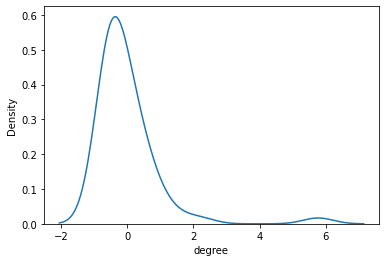

In [88]:
# Plot the kernel density estimate (KDE)
# -> method for visualizing the distribution of observations in a dataset, analagous to a histogram.
# KDE represents the data using a continuous probability density curve in one or more dimensions.
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

sns.kdeplot(euCap_result.degree)

<AxesSubplot:xlabel='eigenvector', ylabel='Density'>

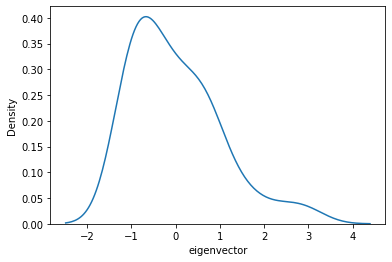

In [106]:
sns.kdeplot(euCap_result.eigenvector)

<AxesSubplot:xlabel='pagerank', ylabel='Density'>

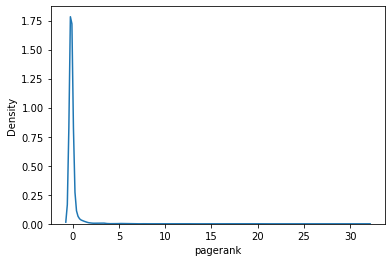

In [114]:
sns.kdeplot(musicGenres_resultNorm.pagerank)#,log_scale=True)

In [91]:
euCap_resultNorm = catMergerNorm(df_euCap, df_ig_gcm)

euCap_resultNorm.head()

Dataframe merged with shape: (52, 5)
Rows with NaN values dropped: 0 from 52 => 0.0% 


,resource,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/European_Capital_o...,European Capital of Culture,-0.676715,-1.107239,-0.691501
1,http://dbpedia.org/resource/Podgorica,Podgorica,-0.535232,-0.008673,-0.552313
2,http://dbpedia.org/resource/City_of_San_Marino,City of San Marino,-0.650080,-1.057383,-0.665622
3,http://dbpedia.org/resource/Gibraltar,Gibraltar,-0.518621,-0.821540,-0.515938
4,http://dbpedia.org/resource/European_Youth_Cap...,European Youth Capital,-0.676429,-1.113411,-0.691367


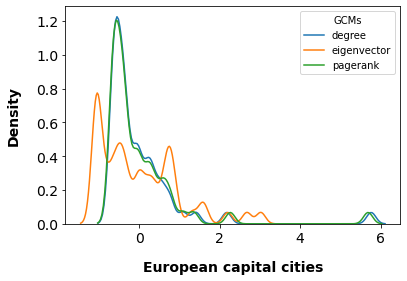

In [92]:
kdeplots(euCap_resultNorm, 'European capital cities')

Dataframe merged with shape: (10000, 5)
Rows with NaN values dropped: 4210 from 10000 => 42.1% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


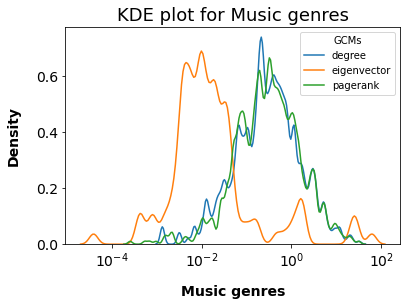

In [117]:
musicGenres_resultNorm = catMergerNorm(df_musicGenre, df_ig_gcm)

kdeplots(musicGenres_resultNorm, 'Music genres')

Dataframe merged with shape: (48, 5)
Rows with NaN values dropped: 1 from 48 => 2.08% 


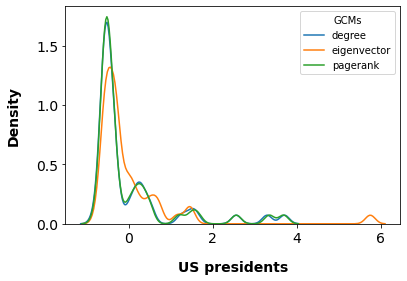

In [94]:
potus_resultNorm = catMergerNorm(df_potus, df_ig_gcm)

kdeplots(potus_resultNorm, 'US presidents')

Dataframe merged with shape: (10000, 5)
Rows with NaN values dropped: 665 from 10000 => 6.65% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


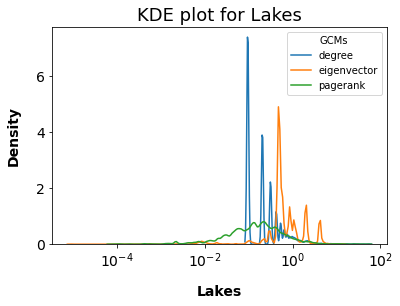

In [118]:
lakes_resultNorm = catMergerNorm(df_lake, df_ig_gcm)

kdeplots(lakes_resultNorm, 'Lakes')

Dataframe merged with shape: (10000, 5)
Rows with NaN values dropped: 935 from 10000 => 9.35% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


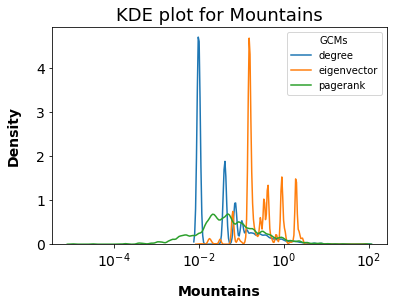

In [119]:
mountains_resultNorm = catMergerNorm(df_mountain, df_ig_gcm)

kdeplots(mountains_resultNorm, 'Mountains')

Dataframe merged with shape: (51, 5)
Rows with NaN values dropped: 0 from 51 => 0.0% 


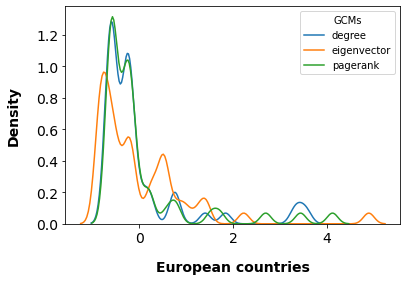

In [97]:
euCou_resultNorm = catMergerNorm(df_euCou, df_ig_gcm)

kdeplots(euCou_resultNorm, 'European countries')

Dataframe merged with shape: (60, 5)
Rows with NaN values dropped: 7 from 60 => 11.67% 


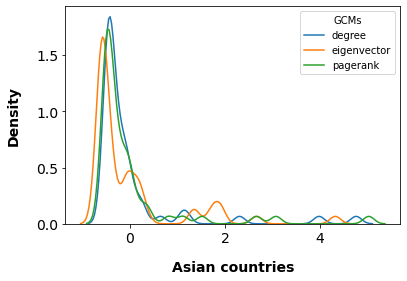

In [98]:
asCou_resultNorm = catMergerNorm(df_asCou, df_ig_gcm)

kdeplots(asCou_resultNorm, 'Asian countries')

Dataframe merged with shape: (10000, 5)
Rows with NaN values dropped: 8628 from 10000 => 86.28% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


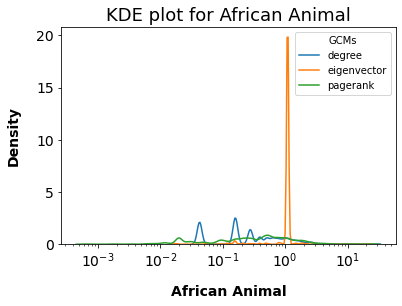

In [120]:
africanAnimal_resultNorm = catMergerNorm(df_africanAnimal, df_ig_gcm)

kdeplots(africanAnimal_resultNorm, 'African Animal')

Dataframe merged with shape: (20, 5)
Rows with NaN values dropped: 5 from 20 => 25.0% 


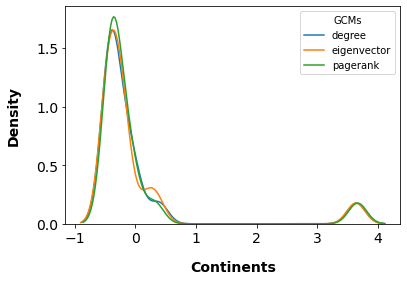

In [100]:
continents_resultNorm = catMergerNorm(df_continent, df_ig_gcm)

kdeplots(continents_resultNorm, 'Continents')

Dataframe merged with shape: (3742, 5)
Rows with NaN values dropped: 1801 from 3742 => 48.13% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


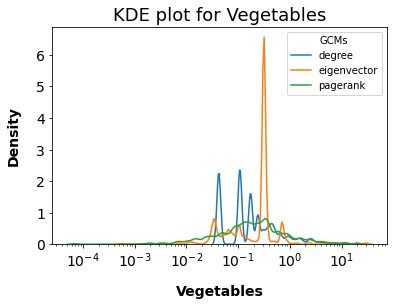

In [121]:
vegetables_resultNorm = catMergerNorm(df_vegetable, df_ig_gcm)

kdeplots(vegetables_resultNorm, 'Vegetables')

Dataframe merged with shape: (4693, 5)
Rows with NaN values dropped: 1006 from 4693 => 21.44% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


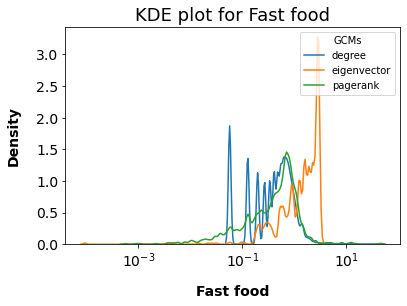

In [122]:
fastFood_resultNorm = catMergerNorm(df_fastFood, df_ig_gcm)

kdeplots(fastFood_resultNorm, 'Fast food')

Dataframe merged with shape: (10000, 5)
Rows with NaN values dropped: 6677 from 10000 => 66.77% 


/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kvnstz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


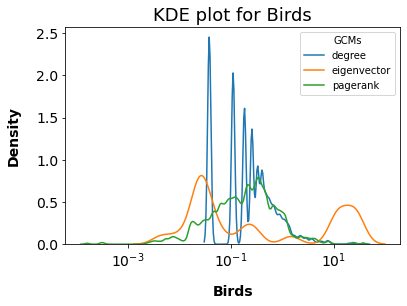

In [123]:
birds_resultNorm = catMergerNorm(df_bird, df_ig_gcm)

kdeplots(birds_resultNorm, 'Birds')

### Compare the top ranking results

In [205]:
# Load survey results per category

#sv_nineties_films = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_film90_impr.csv", sep=';')
#sv_actors = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_actors_impr.csv", sep=';')
sv_music_genres = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_music_genres_impr.csv', sep=';', encoding='utf-8')
#sv_books = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_books_impr.csv", sep=';')
#sv_bookAut = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_authors_impr.csv", sep=';')
#sv_politicians = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_politicians_impr.csv", sep=';')
sv_potus = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_potus_impr.csv', sep=';', encoding='utf-8')
#sv_cities = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_cities_impr.csv', sep=';', encoding='utf-8')
sv_lakes = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_lakes_impr.csv", sep=';')
sv_mountains = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_mountains_prep.csv", sep=';')
sv_european_capital_cities = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_capital_cities_impr.csv', sep=';', encoding='utf-8')
sv_european_countries = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_countries_impr.csv', sep=';', encoding='utf-8')
sv_asian_countries = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_asian_countries_impr.csv", sep=';')
sv_continents = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_continents_impr.csv', sep=';', encoding='utf-8')
sv_birds = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_birds_impr.csv', sep=';', encoding='utf-8')
sv_african_animals = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_african_animals_impr.csv", sep=';')
#sv_furniture = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_furniture_impr.csv", sep=';')
sv_vegetables = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_vegetables_impr.csv', sep=';', encoding='utf-8')
sv_fastfood = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_fast_food_impr.csv", sep=';')
#sv_european_landmarks = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_european_landmarks_impr.csv", sep=';')
#sv_dax_companies = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_dax_companies_impr.csv", sep=';')
#sv_us_companies = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_us_companies_impr.csv', sep=';', encoding="ISO-8859-1") # different encoding due to special character (é)
#sv_us_tech_companies = pd.read_csv('../data/survey_single_cat_files/sv_prep_uri/improved_uri/sv_us_tech_companies_impr.csv', sep=';', encoding='utf-8')

In [215]:
# Function for sorting the GCM-Category data
  # input parameters: 
    # cat_data_frame -> merged dataframe of GCM and categories (e.g. potus_resultNorm)
    # gcm_string -> string on which gcm data to sort (e.g. 'pagerank')
    # opt='p' -> option to toogle the sort between top number or percentage ('p' = percentage; 'n' = number)
    # lot_nr=5 -> the top results either in percentage or actual numbers

    
def sort_gcm_cat(cat_data_frame, gcm_string, lot_nr=5, opt='p'):
    sort_df = cat_data_frame.copy()
    gcm_name = gcm_string
    t = lot_nr
    
    sort_df = sort_df.sort_values(by=gcm_name, ascending=False)
    
    if opt == 'p':
        return_df = sort_df.head(int(len(sort_df)*(t/100)))
    elif opt == 'n':
        return_df = sort_df.head(t)

    return return_df

In [335]:
# Function for calculating P@k
  # input parameters: 
    # survey_data -> loaded survey data (e.g. sv_potus)
    # cat_gcm_data -> merged dataframe of GCM and categories (e.g. potus_resultNorm)
    # gcm_string -> string on which gcm data to sort (e.g. 'pagerank')
    # opt='p' -> option to toogle the sort between top number or percentage ('p' = percentage; 'n' = number)
    # lot_nr=5 -> the top results either in percentage or actual numbers (e.g. 10)

def precisionAtK(survey_data, cat_gcm_data, gcm_string, lot_nr=5, opt='p'): 
    # Prepare survey data
    df_survey = survey_data.copy()
    
    df_survey.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe
    survey_count = df_survey['resource'].value_counts()#count how often an answer was given in the survey
    df_survey_counted = pd.DataFrame({'resource':survey_count.index, 'amount':survey_count.values})

    # Prepare GCM data
    df_cat_gcm = cat_gcm_data.copy()
    gcm_name = gcm_string
    t = lot_nr
    
    df_cat_gcm = df_cat_gcm.sort_values(by=gcm_name, ascending=False)
    if opt == 'p':
        df_cat_gcm = df_cat_gcm.head(int(len(df_cat_gcm)*(t/100)))
    elif opt == 'n':
        df_cat_gcm = df_cat_gcm.head(t)

    # Merge top t from the GCM into survey category based on the URI -> successful merges are hits
    df_survey_gcm = pd.merge(df_survey_counted,
                df_cat_gcm[['resource','name', 'degree','eigenvector','pagerank']],
                on='resource', 
                how='left')
    
    # Get rows that were not matched with the category and calculate P@k
    nan_rows = df_survey_gcm.shape[0] - df_survey_gcm.dropna().shape[0]
    hits = df_survey_gcm.shape[0]-nan_rows
    
    if opt == 'p':
        p_at_k = hits/df_cat_gcm.shape[0]
    elif opt == 'n':
        p_at_k = hits/t
    
    print("Precision at k={}".format(t) +" ({})".format(opt) + " for {}".format(gcm_name.upper()))
    print('-------------------------------------')
    print("Entries in the DBpedia category: {}".format(cat_gcm_data.shape[0]))
    print("DBpedia entries taken: top {}".format(df_cat_gcm.shape[0]))
    print("Entries in the gold standard: {}".format(df_survey_counted.shape[0]))
    print('-------------------------------------')
    print("HITS: {}".format(hits))
    print("P@{}".format(t) + ": {}".format(p_at_k))
    print('=====================================')
    
    return df_survey_gcm

In [273]:
n = 1 # percentage of top results

musicGenres_result_sort = musicGenres_resultNorm.sort_values(by='degree', ascending=False)
musicGenres_result_sort.head(int(len(musicGenres_result_sort)*(n/100)))

,resource,name,degree,eigenvector,pagerank
3408,http://dbpedia.org/resource/Pop_music,Pop music,32.201888,0.037286,31.603269
2577,http://dbpedia.org/resource/Country_music,Country music,23.133426,-0.029161,23.206595
1822,http://dbpedia.org/resource/Alternative_rock,Alternative rock,20.722094,0.005411,20.150214
2916,http://dbpedia.org/resource/Rock_music,Rock music,19.965306,0.012149,19.579307
4311,http://dbpedia.org/resource/Hip_hop_music,Hip hop music,18.453587,-0.004172,17.043364
2756,http://dbpedia.org/resource/Jazz,Jazz,15.016511,0.000039,14.861902
3742,http://dbpedia.org/resource/Indie_rock,Indie rock,12.334368,-0.009423,12.410688
2922,http://dbpedia.org/resource/Science_fiction,Science fiction,12.228641,0.006178,13.588646
5859,http://dbpedia.org/resource/Pop_rock,Pop rock,12.134042,0.018349,11.701975
7736,http://dbpedia.org/resource/Contemporary_R&B,Contemporary R&B,11.742665,-0.024771,10.720268


### Music genres

In [341]:
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 1
Entries in the gold standard: 38
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 5
Entries in the gold standard: 38
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 10
Entries in the gold standard: 38
-------------------------------------
HITS: 6
P@10: 0.6
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 57
Entries in the gold standard: 38
-------------------------------------
HITS: 19
P@1: 0.3333333333333333
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Rock_music,56,Rock music,19.965306,0.012149,19.579307
1,http://dbpedia.org/resource/Pop_music,51,Pop music,32.201888,0.037286,31.603269
2,http://dbpedia.org/resource/Hip_hop_music,51,Hip hop music,18.453587,-0.004172,17.043364
3,http://dbpedia.org/resource/Jazz,27,Jazz,15.016511,0.000039,14.861902
4,http://dbpedia.org/resource/Classical_music,26,Classical music,4.898192,0.009477,5.268666
5,http://dbpedia.org/resource/Heavy_metal_music,20,Heavy metal music,7.240894,-0.022154,6.728153
6,http://dbpedia.org/resource/Techno,20,Techno,1.405470,-0.034476,1.337463
7,http://dbpedia.org/resource/House_music,8,House music,4.280520,0.000865,4.058736
8,http://dbpedia.org/resource/Rhythm_and_blues,7,Rhythm and blues,9.587305,-0.023769,8.901624
9,http://dbpedia.org/resource/Indie_rock,6,Indie rock,12.334368,-0.009423,12.410688


In [340]:
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 1
Entries in the gold standard: 38
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 5
Entries in the gold standard: 38
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 10
Entries in the gold standard: 38
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 57
Entries in the gold standard: 38
-------------------------------------
HITS: 2
P@1: 0.03508771929824561
Precision at k=2 (p) for EIGENVECTOR
-----------------------

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Rock_music,56,Rock music,19.965306,0.012149,19.579307
1,http://dbpedia.org/resource/Pop_music,51,Pop music,32.201888,0.037286,31.603269
2,http://dbpedia.org/resource/Hip_hop_music,51,Hip hop music,18.453587,-0.004172,17.043364
3,http://dbpedia.org/resource/Jazz,27,Jazz,15.016511,0.000039,14.861902
4,http://dbpedia.org/resource/Classical_music,26,Classical music,4.898192,0.009477,5.268666
5,http://dbpedia.org/resource/Heavy_metal_music,20,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Techno,20,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/House_music,8,House music,4.280520,0.000865,4.058736
8,http://dbpedia.org/resource/Rhythm_and_blues,7,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Indie_rock,6,NaN,NaN,NaN,NaN


In [339]:
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_music_genres, musicGenres_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 1
Entries in the gold standard: 38
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 5
Entries in the gold standard: 38
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 10
Entries in the gold standard: 38
-------------------------------------
HITS: 6
P@10: 0.6
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 5790
DBpedia entries taken: top 57
Entries in the gold standard: 38
-------------------------------------
HITS: 19
P@1: 0.3333333333333333
Precision at k=2 (p) for PAGERANK
-------------------------------------


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Rock_music,56,Rock music,19.965306,0.012149,19.579307
1,http://dbpedia.org/resource/Pop_music,51,Pop music,32.201888,0.037286,31.603269
2,http://dbpedia.org/resource/Hip_hop_music,51,Hip hop music,18.453587,-0.004172,17.043364
3,http://dbpedia.org/resource/Jazz,27,Jazz,15.016511,0.000039,14.861902
4,http://dbpedia.org/resource/Classical_music,26,Classical music,4.898192,0.009477,5.268666
5,http://dbpedia.org/resource/Heavy_metal_music,20,Heavy metal music,7.240894,-0.022154,6.728153
6,http://dbpedia.org/resource/Techno,20,Techno,1.405470,-0.034476,1.337463
7,http://dbpedia.org/resource/House_music,8,House music,4.280520,0.000865,4.058736
8,http://dbpedia.org/resource/Rhythm_and_blues,7,Rhythm and blues,9.587305,-0.023769,8.901624
9,http://dbpedia.org/resource/Indie_rock,6,Indie rock,12.334368,-0.009423,12.410688


### US presidents

In [346]:
precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=10, opt='n')

#precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=1, opt='p')
#precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_potus, potus_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 1
Entries in the gold standard: 19
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 5
Entries in the gold standard: 19
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 10
Entries in the gold standard: 19
-------------------------------------
HITS: 10
P@10: 1.0
Precision at k=5 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 2
Entries in the gold standard: 19
-------------------------------------
HITS: 2
P@5: 1.0
Precision at k=10 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Barack_Obama,77,Barack Obama,3.708055,-0.352442,3.687696
1,http://dbpedia.org/resource/Donald_Trump,59,Donald Trump,3.295256,-0.525472,3.347980
2,http://dbpedia.org/resource/Joe_Biden,50,Joe Biden,1.604187,-0.478987,1.641248
3,http://dbpedia.org/resource/George_W._Bush,37,George W. Bush,2.558785,0.603578,2.562086
4,http://dbpedia.org/resource/Abraham_Lincoln,19,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/John_F._Kennedy,17,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Bill_Clinton,15,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/George_Washington,14,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Franklin_D._Roosevelt,10,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Ronald_Reagan,5,NaN,NaN,NaN,NaN


In [348]:
precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=10, opt='n')

#precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=1, opt='p')
#precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_potus, potus_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 1
Entries in the gold standard: 19
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 5
Entries in the gold standard: 19
-------------------------------------
HITS: 2
P@5: 0.4
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 10
Entries in the gold standard: 19
-------------------------------------
HITS: 6
P@10: 0.6
Precision at k=5 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 2
Entries in the gold standard: 19
-------------------------------------
HITS: 1
P@5: 0.5
Precision at k=10 (p) for EIGENVECTOR
-------------------------------------
Entries i

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Barack_Obama,77,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Donald_Trump,59,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Joe_Biden,50,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/George_W._Bush,37,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Abraham_Lincoln,19,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/John_F._Kennedy,17,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Bill_Clinton,15,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/George_Washington,14,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Franklin_D._Roosevelt,10,Franklin D. Roosevelt,0.328263,1.156010,0.330174
9,http://dbpedia.org/resource/Ronald_Reagan,5,NaN,NaN,NaN,NaN


In [349]:
precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=10, opt='n')

#precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=1, opt='p')
#precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_potus, potus_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 1
Entries in the gold standard: 19
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 5
Entries in the gold standard: 19
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 10
Entries in the gold standard: 19
-------------------------------------
HITS: 10
P@10: 1.0
Precision at k=5 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 47
DBpedia entries taken: top 2
Entries in the gold standard: 19
-------------------------------------
HITS: 2
P@5: 1.0
Precision at k=10 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia 

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Barack_Obama,77,Barack Obama,3.708055,-0.352442,3.687696
1,http://dbpedia.org/resource/Donald_Trump,59,Donald Trump,3.295256,-0.525472,3.347980
2,http://dbpedia.org/resource/Joe_Biden,50,Joe Biden,1.604187,-0.478987,1.641248
3,http://dbpedia.org/resource/George_W._Bush,37,George W. Bush,2.558785,0.603578,2.562086
4,http://dbpedia.org/resource/Abraham_Lincoln,19,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/John_F._Kennedy,17,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Bill_Clinton,15,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/George_Washington,14,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Franklin_D._Roosevelt,10,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Ronald_Reagan,5,NaN,NaN,NaN,NaN


### Lakes

In [350]:
precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 1
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 5
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 10
Entries in the gold standard: 70
-------------------------------------
HITS: 1
P@10: 0.1
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 93
Entries in the gold standard: 70
-------------------------------------
HITS: 16
P@1: 0.17204301075268819
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries i

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Lake_Constance,70,Lake Constance,2.522217,-0.738777,2.966051
1,http://dbpedia.org/resource/Lake_Garda,22,Lake Garda,1.088362,4.174926,1.201136
2,http://dbpedia.org/resource/Michigan,15,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Chiemsee,15,Chiemsee,0.426582,0.488262,0.643024
4,http://dbpedia.org/resource/Lake_Victoria,13,Lake Victoria,4.176666,-0.282357,3.991495
...,...,...,...,...,...,...
65,http://dbpedia.org/resource/Rhine,1,NaN,NaN,NaN,NaN
66,http://dbpedia.org/resource/Walchensee,1,Walchensee,0.205989,0.484088,0.346317
67,http://dbpedia.org/resource/Sacrower_See,1,NaN,NaN,NaN,NaN
68,http://dbpedia.org/resource/Liepnitzsee,1,NaN,NaN,NaN,NaN


In [351]:
precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 1
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 5
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 10
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 93
Entries in the gold standard: 70
-------------------------------------
HITS: 3
P@1: 0.03225806451612903
Precision at k=2 (p) for EIGENVECTOR
-----------------------

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Lake_Constance,70,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Lake_Garda,22,Lake Garda,1.088362,4.174926,1.201136
2,http://dbpedia.org/resource/Michigan,15,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Chiemsee,15,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Lake_Victoria,13,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
65,http://dbpedia.org/resource/Rhine,1,NaN,NaN,NaN,NaN
66,http://dbpedia.org/resource/Walchensee,1,NaN,NaN,NaN,NaN
67,http://dbpedia.org/resource/Sacrower_See,1,NaN,NaN,NaN,NaN
68,http://dbpedia.org/resource/Liepnitzsee,1,NaN,NaN,NaN,NaN


In [352]:
precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_lakes, lakes_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 1
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 5
Entries in the gold standard: 70
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 10
Entries in the gold standard: 70
-------------------------------------
HITS: 1
P@10: 0.1
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9335
DBpedia entries taken: top 93
Entries in the gold standard: 70
-------------------------------------
HITS: 15
P@1: 0.16129032258064516
Precision at k=2 (p) for PAGERANK
-------------------------------------

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Lake_Constance,70,Lake Constance,2.522217,-0.738777,2.966051
1,http://dbpedia.org/resource/Lake_Garda,22,Lake Garda,1.088362,4.174926,1.201136
2,http://dbpedia.org/resource/Michigan,15,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Chiemsee,15,Chiemsee,0.426582,0.488262,0.643024
4,http://dbpedia.org/resource/Lake_Victoria,13,Lake Victoria,4.176666,-0.282357,3.991495
...,...,...,...,...,...,...
65,http://dbpedia.org/resource/Rhine,1,NaN,NaN,NaN,NaN
66,http://dbpedia.org/resource/Walchensee,1,Walchensee,0.205989,0.484088,0.346317
67,http://dbpedia.org/resource/Sacrower_See,1,NaN,NaN,NaN,NaN
68,http://dbpedia.org/resource/Liepnitzsee,1,NaN,NaN,NaN,NaN


### Mountains

In [353]:
precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 1
Entries in the gold standard: 56
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 5
Entries in the gold standard: 56
-------------------------------------
HITS: 1
P@5: 0.2
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 10
Entries in the gold standard: 56
-------------------------------------
HITS: 2
P@10: 0.2
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 90
Entries in the gold standard: 56
-------------------------------------
HITS: 7
P@1: 0.07777777777777778
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Mount_Everest,68,Mount Everest,1.969125,-0.150577,2.157380
1,http://dbpedia.org/resource/Zugspitze,65,Zugspitze,0.162833,0.656033,0.178419
2,http://dbpedia.org/resource/K2,29,K2,0.377139,-0.432434,0.448797
3,http://dbpedia.org/resource/Mount_Kilimanjaro,21,Mount Kilimanjaro,0.744520,-0.417605,0.906696
4,http://dbpedia.org/resource/Chamonix,21,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Matterhorn_Gotthar...,19,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Feldberg_(Black_Fo...,9,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Pennine_Alps,7,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Brocken_spectre,5,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Nanga_Parbat,4,Nanga Parbat,0.193448,-0.433027,0.256582


In [354]:
precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 1
Entries in the gold standard: 56
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 5
Entries in the gold standard: 56
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 10
Entries in the gold standard: 56
-------------------------------------
HITS: 1
P@10: 0.1
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 90
Entries in the gold standard: 56
-------------------------------------
HITS: 1
P@1: 0.011111111111111112
Precision at k=2 (p) for EIGENVECTOR
----------------------

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Mount_Everest,68,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Zugspitze,65,Zugspitze,0.162833,0.656033,0.178419
2,http://dbpedia.org/resource/K2,29,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Mount_Kilimanjaro,21,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Chamonix,21,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Matterhorn_Gotthar...,19,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Feldberg_(Black_Fo...,9,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Pennine_Alps,7,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Brocken_spectre,5,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Nanga_Parbat,4,NaN,NaN,NaN,NaN


In [355]:
precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_mountains, mountains_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 1
Entries in the gold standard: 56
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 5
Entries in the gold standard: 56
-------------------------------------
HITS: 1
P@5: 0.2
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 10
Entries in the gold standard: 56
-------------------------------------
HITS: 3
P@10: 0.3
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 9065
DBpedia entries taken: top 90
Entries in the gold standard: 56
-------------------------------------
HITS: 8
P@1: 0.08888888888888889
Precision at k=2 (p) for PAGERANK
-------------------------------------


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Mount_Everest,68,Mount Everest,1.969125,-0.150577,2.157380
1,http://dbpedia.org/resource/Zugspitze,65,Zugspitze,0.162833,0.656033,0.178419
2,http://dbpedia.org/resource/K2,29,K2,0.377139,-0.432434,0.448797
3,http://dbpedia.org/resource/Mount_Kilimanjaro,21,Mount Kilimanjaro,0.744520,-0.417605,0.906696
4,http://dbpedia.org/resource/Chamonix,21,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Matterhorn_Gotthar...,19,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Feldberg_(Black_Fo...,9,Feldberg (Black Forest),0.009757,-0.396636,0.043429
7,http://dbpedia.org/resource/Pennine_Alps,7,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Brocken_spectre,5,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Nanga_Parbat,4,Nanga Parbat,0.193448,-0.433027,0.256582


### European capital cities

In [357]:
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=10, opt='n')

#precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 1
Entries in the gold standard: 28
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 5
Entries in the gold standard: 28
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 10
Entries in the gold standard: 28
-------------------------------------
HITS: 10
P@10: 1.0
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 1
Entries in the gold standard: 28
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 5

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Berlin,84,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Paris,74,Paris,2.174713,0.671928,2.264122
2,http://dbpedia.org/resource/London,45,London,5.766493,2.675248,5.688451
3,http://dbpedia.org/resource/Rome,29,Rome,1.090678,0.751011,1.083243
4,http://dbpedia.org/resource/Madrid,19,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Vienna,9,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/City_of_Brussels,8,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Warsaw,7,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Copenhagen,7,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Helsinki,5,NaN,NaN,NaN,NaN


In [359]:
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=10, opt='n')

#precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 1
Entries in the gold standard: 28
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 5
Entries in the gold standard: 28
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 10
Entries in the gold standard: 28
-------------------------------------
HITS: 9
P@10: 0.9
Precision at k=2 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 1
Entries in the gold standard: 28
-------------------------------------
HITS: 0
P@2: 0.0
Precision at k=5 (p) for EIGENVECTOR
-------------------------------------
Entries in

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Berlin,84,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Paris,74,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/London,45,London,5.766493,2.675248,5.688451
3,http://dbpedia.org/resource/Rome,29,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Madrid,19,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Vienna,9,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/City_of_Brussels,8,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Warsaw,7,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Copenhagen,7,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Helsinki,5,NaN,NaN,NaN,NaN


In [360]:
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=10, opt='n')

#precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_european_capital_cities, euCap_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 1
Entries in the gold standard: 28
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 5
Entries in the gold standard: 28
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 10
Entries in the gold standard: 28
-------------------------------------
HITS: 10
P@10: 1.0
Precision at k=2 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 52
DBpedia entries taken: top 1
Entries in the gold standard: 28
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia c

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Berlin,84,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Paris,74,Paris,2.174713,0.671928,2.264122
2,http://dbpedia.org/resource/London,45,London,5.766493,2.675248,5.688451
3,http://dbpedia.org/resource/Rome,29,Rome,1.090678,0.751011,1.083243
4,http://dbpedia.org/resource/Madrid,19,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Vienna,9,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/City_of_Brussels,8,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Warsaw,7,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Copenhagen,7,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Helsinki,5,NaN,NaN,NaN,NaN


### European countries

In [363]:
precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=10, opt='n')

#precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 1
Entries in the gold standard: 29
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 5
Entries in the gold standard: 29
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 10
Entries in the gold standard: 29
-------------------------------------
HITS: 8
P@10: 0.8
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 1
Entries in the gold standard: 29
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 51

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Germany,80,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/France,66,France,3.424141,1.017289,4.113717
2,http://dbpedia.org/resource/Italy,38,Italy,1.405014,4.885709,1.531766
3,http://dbpedia.org/resource/Spain,30,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/United_Kingdom,13,United Kingdom,3.299405,-0.754920,3.433746
5,http://dbpedia.org/resource/Poland,13,Poland,3.571259,1.425449,2.692511
6,http://dbpedia.org/resource/Austria,12,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Sweden,11,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Switzerland,11,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Denmark,10,NaN,NaN,NaN,NaN


In [364]:
precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=10, opt='n')

#precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 1
Entries in the gold standard: 29
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 5
Entries in the gold standard: 29
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 10
Entries in the gold standard: 29
-------------------------------------
HITS: 8
P@10: 0.8
Precision at k=2 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 1
Entries in the gold standard: 29
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for EIGENVECTOR
-------------------------------------
Entries in

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Germany,80,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/France,66,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Italy,38,Italy,1.405014,4.885709,1.531766
3,http://dbpedia.org/resource/Spain,30,Spain,0.789731,2.224985,0.731091
4,http://dbpedia.org/resource/United_Kingdom,13,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Poland,13,Poland,3.571259,1.425449,2.692511
6,http://dbpedia.org/resource/Austria,12,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Sweden,11,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Switzerland,11,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Denmark,10,NaN,NaN,NaN,NaN


In [365]:
precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=10, opt='n')

#precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_european_countries, euCou_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 1
Entries in the gold standard: 29
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 5
Entries in the gold standard: 29
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 10
Entries in the gold standard: 29
-------------------------------------
HITS: 8
P@10: 0.8
Precision at k=2 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 51
DBpedia entries taken: top 1
Entries in the gold standard: 29
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia ca

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Germany,80,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/France,66,France,3.424141,1.017289,4.113717
2,http://dbpedia.org/resource/Italy,38,Italy,1.405014,4.885709,1.531766
3,http://dbpedia.org/resource/Spain,30,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/United_Kingdom,13,United Kingdom,3.299405,-0.754920,3.433746
5,http://dbpedia.org/resource/Poland,13,Poland,3.571259,1.425449,2.692511
6,http://dbpedia.org/resource/Austria,12,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Sweden,11,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Switzerland,11,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Denmark,10,NaN,NaN,NaN,NaN


### Asian countries

In [367]:
precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=10, opt='n')

#precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 1
Entries in the gold standard: 33
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 5
Entries in the gold standard: 33
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 10
Entries in the gold standard: 33
-------------------------------------
HITS: 10
P@10: 1.0
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 1
Entries in the gold standard: 33
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 5

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/China,83,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Japan,61,Japan,1.190795,4.319159,1.516850
2,http://dbpedia.org/resource/India,25,India,4.757256,0.166922,5.022889
3,http://dbpedia.org/resource/South_Korea,24,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Thailand,23,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Vietnam,20,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Indonesia,16,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Singapore,9,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Taiwan,9,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Cambodia,6,NaN,NaN,NaN,NaN


In [368]:
precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=10, opt='n')

#precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 1
Entries in the gold standard: 33
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 5
Entries in the gold standard: 33
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 10
Entries in the gold standard: 33
-------------------------------------
HITS: 8
P@10: 0.8
Precision at k=2 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 1
Entries in the gold standard: 33
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for EIGENVECTOR
-------------------------------------
Entries in

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/China,83,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Japan,61,Japan,1.190795,4.319159,1.516850
2,http://dbpedia.org/resource/India,25,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/South_Korea,24,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Thailand,23,Thailand,-0.041661,1.771082,-0.002353
5,http://dbpedia.org/resource/Vietnam,20,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Indonesia,16,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Singapore,9,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Taiwan,9,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Cambodia,6,NaN,NaN,NaN,NaN


In [369]:
precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=10, opt='n')

#precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_asian_countries, asCou_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 1
Entries in the gold standard: 33
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 5
Entries in the gold standard: 33
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 10
Entries in the gold standard: 33
-------------------------------------
HITS: 10
P@10: 1.0
Precision at k=2 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 53
DBpedia entries taken: top 1
Entries in the gold standard: 33
-------------------------------------
HITS: 1
P@2: 1.0
Precision at k=5 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia c

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/China,83,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Japan,61,Japan,1.190795,4.319159,1.516850
2,http://dbpedia.org/resource/India,25,India,4.757256,0.166922,5.022889
3,http://dbpedia.org/resource/South_Korea,24,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Thailand,23,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Vietnam,20,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Indonesia,16,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Singapore,9,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Taiwan,9,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Cambodia,6,NaN,NaN,NaN,NaN


### Continents

In [373]:
precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=10, opt='n')

#precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=1, opt='p')
#precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=2, opt='p')
#precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_continents, continents_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 1
Entries in the gold standard: 8
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 5
Entries in the gold standard: 8
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 10
Entries in the gold standard: 8
-------------------------------------
HITS: 7
P@10: 0.7
Precision at k=10 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 1
Entries in the gold standard: 8
-------------------------------------
HITS: 1
P@10: 1.0


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Europe,94,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Africa,77,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Asia,77,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/North_America,34,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Australia_(continent),23,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/South_America,11,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Antarctica,6,Antarctica,3.644978,-0.433297,3.667496
7,http://dbpedia.org/resource/Oceania,1,NaN,NaN,NaN,NaN


In [374]:
precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=10, opt='n')

#precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=1, opt='p')
#precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=2, opt='p')
#precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_continents, continents_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 1
Entries in the gold standard: 8
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 5
Entries in the gold standard: 8
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 10
Entries in the gold standard: 8
-------------------------------------
HITS: 6
P@10: 0.6
Precision at k=10 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 1
Entries in the gold standard: 8
-------------------------------------
HITS: 1
P@10: 1.0


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Europe,94,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Africa,77,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Asia,77,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/North_America,34,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Australia_(continent),23,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/South_America,11,South America,-0.241534,3.639627,-0.252906
6,http://dbpedia.org/resource/Antarctica,6,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Oceania,1,NaN,NaN,NaN,NaN


In [376]:
precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=10, opt='n')

#precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=1, opt='p')
#precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=2, opt='p')
#precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_continents, continents_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 1
Entries in the gold standard: 8
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 5
Entries in the gold standard: 8
-------------------------------------
HITS: 5
P@5: 1.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 10
Entries in the gold standard: 8
-------------------------------------
HITS: 7
P@10: 0.7
Precision at k=10 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 15
DBpedia entries taken: top 1
Entries in the gold standard: 8
-------------------------------------
HITS: 1
P@10: 1.0


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Europe,94,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Africa,77,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Asia,77,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/North_America,34,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Australia_(continent),23,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/South_America,11,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Antarctica,6,Antarctica,3.644978,-0.433297,3.667496
7,http://dbpedia.org/resource/Oceania,1,NaN,NaN,NaN,NaN


### Birds

In [377]:
precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 1
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 5
Entries in the gold standard: 50
-------------------------------------
HITS: 1
P@5: 0.2
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 10
Entries in the gold standard: 50
-------------------------------------
HITS: 1
P@10: 0.1
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 33
Entries in the gold standard: 50
-------------------------------------
HITS: 1
P@1: 0.030303030303030304
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries i

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Eagle,45,Eagle,1.633233,-0.057304,1.563316
1,http://dbpedia.org/resource/Sparrow,22,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Common_blackbird,19,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Robin,18,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Columbidae,15,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Hummingbird,12,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Owl,10,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Crow,10,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Parrot,10,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Raven,9,NaN,NaN,NaN,NaN


In [378]:
precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 1
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 5
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 10
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 33
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=2 (p) for EIGENVECTOR
-------------------------------------
E

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Eagle,45,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Sparrow,22,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Common_blackbird,19,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Robin,18,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Columbidae,15,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Hummingbird,12,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Owl,10,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Crow,10,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Parrot,10,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Raven,9,Raven,-0.106846,-0.031119,-0.058493


In [379]:
precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_birds, birds_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 1
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 5
Entries in the gold standard: 50
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 10
Entries in the gold standard: 50
-------------------------------------
HITS: 1
P@10: 0.1
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3323
DBpedia entries taken: top 33
Entries in the gold standard: 50
-------------------------------------
HITS: 1
P@1: 0.030303030303030304
Precision at k=2 (p) for PAGERANK
-------------------------------------

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Eagle,45,Eagle,1.633233,-0.057304,1.563316
1,http://dbpedia.org/resource/Sparrow,22,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/Common_blackbird,19,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Robin,18,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Columbidae,15,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Hummingbird,12,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Owl,10,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Crow,10,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Parrot,10,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Raven,9,NaN,NaN,NaN,NaN


### African animals

In [380]:
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 1
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 5
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 10
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 13
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in the DBpedia cat

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Lion,79,Lion,1.675403,1.176816,2.352187
1,http://dbpedia.org/resource/Elephant,79,Elephant,1.675403,1.107624,3.119400
2,http://dbpedia.org/resource/Giraffe,52,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Zebra,39,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Rhinoceros,10,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Hippopotamus,9,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Antelope,8,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Tiger,6,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Hyena,6,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Cheetah,4,NaN,NaN,NaN,NaN


In [381]:
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 1
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 5
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 10
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 13
Entries in the gold standard: 25
-------------------------------------
HITS: 1
P@1: 0.07692307692307693
Precision at k=2 (p) for EIGENVECTOR
-----------------------

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Lion,79,Lion,1.675403,1.176816,2.352187
1,http://dbpedia.org/resource/Elephant,79,Elephant,1.675403,1.107624,3.119400
2,http://dbpedia.org/resource/Giraffe,52,Giraffe,0.159218,1.093225,0.905268
3,http://dbpedia.org/resource/Zebra,39,Zebra,-0.190671,1.094520,-0.065516
4,http://dbpedia.org/resource/Rhinoceros,10,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Hippopotamus,9,Hippopotamus,-0.423930,1.092840,-0.322403
6,http://dbpedia.org/resource/Antelope,8,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Tiger,6,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Hyena,6,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Cheetah,4,NaN,NaN,NaN,NaN


In [382]:
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_african_animals, africanAnimal_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 1
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 5
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 10
Entries in the gold standard: 25
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1372
DBpedia entries taken: top 13
Entries in the gold standard: 25
-------------------------------------
HITS: 1
P@1: 0.07692307692307693
Precision at k=2 (p) for PAGERANK
-------------------------------------


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Lion,79,Lion,1.675403,1.176816,2.352187
1,http://dbpedia.org/resource/Elephant,79,Elephant,1.675403,1.107624,3.119400
2,http://dbpedia.org/resource/Giraffe,52,Giraffe,0.159218,1.093225,0.905268
3,http://dbpedia.org/resource/Zebra,39,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Rhinoceros,10,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Hippopotamus,9,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Antelope,8,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Tiger,6,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Hyena,6,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Cheetah,4,NaN,NaN,NaN,NaN


### Vegetables

In [383]:
precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 1
Entries in the gold standard: 37
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 5
Entries in the gold standard: 37
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 10
Entries in the gold standard: 37
-------------------------------------
HITS: 4
P@10: 0.4
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 19
Entries in the gold standard: 37
-------------------------------------
HITS: 6
P@1: 0.3157894736842105
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in 

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Carrot,51,Carrot,3.533501,0.324573,3.479786
1,http://dbpedia.org/resource/Cucumber,47,Cucumber,1.754923,0.317726,1.737238
2,http://dbpedia.org/resource/Tomato,43,Tomato,11.570037,0.348644,11.056798
3,http://dbpedia.org/resource/Potato,19,Potato,18.486729,0.345457,19.924285
4,http://dbpedia.org/resource/Broccoli,18,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Zucchini,17,Zucchini,0.305712,-0.190943,0.419327
6,http://dbpedia.org/resource/Eggplant,17,Eggplant,2.150163,0.320709,2.069660
7,http://dbpedia.org/resource/Bell_pepper,14,Bell pepper,2.413656,-0.187573,2.235934
8,http://dbpedia.org/resource/Paprika,11,Paprika,0.832698,-0.189405,0.755452
9,http://dbpedia.org/resource/Onion,11,Onion,21.385152,0.359892,20.336650


In [384]:
precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 1
Entries in the gold standard: 37
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 5
Entries in the gold standard: 37
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 10
Entries in the gold standard: 37
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 19
Entries in the gold standard: 37
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=2 (p) for EIGENVECTOR
-------------------------------------
E

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Carrot,51,Carrot,3.533501,0.324573,3.479786
1,http://dbpedia.org/resource/Cucumber,47,Cucumber,1.754923,0.317726,1.737238
2,http://dbpedia.org/resource/Tomato,43,Tomato,11.570037,0.348644,11.056798
3,http://dbpedia.org/resource/Potato,19,Potato,18.486729,0.345457,19.924285
4,http://dbpedia.org/resource/Broccoli,18,Broccoli,0.108092,0.701546,0.166846
5,http://dbpedia.org/resource/Zucchini,17,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Eggplant,17,Eggplant,2.150163,0.320709,2.069660
7,http://dbpedia.org/resource/Bell_pepper,14,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Paprika,11,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Onion,11,Onion,21.385152,0.359892,20.336650


In [385]:
precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_vegetables, vegetables_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 1
Entries in the gold standard: 37
-------------------------------------
HITS: 1
P@1: 1.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 5
Entries in the gold standard: 37
-------------------------------------
HITS: 4
P@5: 0.8
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 10
Entries in the gold standard: 37
-------------------------------------
HITS: 4
P@10: 0.4
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 1941
DBpedia entries taken: top 19
Entries in the gold standard: 37
-------------------------------------
HITS: 5
P@1: 0.2631578947368421
Precision at k=2 (p) for PAGERANK
-------------------------------------
E

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Carrot,51,Carrot,3.533501,0.324573,3.479786
1,http://dbpedia.org/resource/Cucumber,47,Cucumber,1.754923,0.317726,1.737238
2,http://dbpedia.org/resource/Tomato,43,Tomato,11.570037,0.348644,11.056798
3,http://dbpedia.org/resource/Potato,19,Potato,18.486729,0.345457,19.924285
4,http://dbpedia.org/resource/Broccoli,18,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Zucchini,17,Zucchini,0.305712,-0.190943,0.419327
6,http://dbpedia.org/resource/Eggplant,17,Eggplant,2.150163,0.320709,2.069660
7,http://dbpedia.org/resource/Bell_pepper,14,Bell pepper,2.413656,-0.187573,2.235934
8,http://dbpedia.org/resource/Paprika,11,Paprika,0.832698,-0.189405,0.755452
9,http://dbpedia.org/resource/Onion,11,Onion,21.385152,0.359892,20.336650


### Fast food

In [386]:
precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=1, opt='n')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=5, opt='n')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=10, opt='n')

precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=1, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=2, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=5, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'degree', lot_nr=10, opt='p')

Precision at k=1 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 1
Entries in the gold standard: 27
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 5
Entries in the gold standard: 27
-------------------------------------
HITS: 3
P@5: 0.6
Precision at k=10 (n) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 10
Entries in the gold standard: 27
-------------------------------------
HITS: 4
P@10: 0.4
Precision at k=1 (p) for DEGREE
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 36
Entries in the gold standard: 27
-------------------------------------
HITS: 7
P@1: 0.19444444444444445
Precision at k=2 (p) for DEGREE
-------------------------------------
Entries in

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Hamburger,103,Hamburger,8.155695,-0.494157,8.493798
1,http://dbpedia.org/resource/Pizza,53,Pizza,10.738978,-0.486140,12.520911
2,http://dbpedia.org/resource/French_fries,51,French fries,8.016058,-0.491335,8.299843
3,http://dbpedia.org/resource/Kebab,23,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Hot_dog,17,Hot dog,3.198583,-0.496974,3.368504
5,http://dbpedia.org/resource/Sandwich,10,Sandwich,12.135347,-0.496772,12.470208
6,http://dbpedia.org/resource/Taco,10,Taco,1.383303,-0.496993,1.546622
7,http://dbpedia.org/resource/Chicken_nugget,8,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Sushi,5,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Currywurst,5,NaN,NaN,NaN,NaN


In [387]:
precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=1, opt='n')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=5, opt='n')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=10, opt='n')

precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=1, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=2, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=5, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'eigenvector', lot_nr=10, opt='p')

Precision at k=1 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 1
Entries in the gold standard: 27
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 5
Entries in the gold standard: 27
-------------------------------------
HITS: 0
P@5: 0.0
Precision at k=10 (n) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 10
Entries in the gold standard: 27
-------------------------------------
HITS: 0
P@10: 0.0
Precision at k=1 (p) for EIGENVECTOR
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 36
Entries in the gold standard: 27
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=2 (p) for EIGENVECTOR
-------------------------------------
E

,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Hamburger,103,NaN,NaN,NaN,NaN
1,http://dbpedia.org/resource/Pizza,53,NaN,NaN,NaN,NaN
2,http://dbpedia.org/resource/French_fries,51,NaN,NaN,NaN,NaN
3,http://dbpedia.org/resource/Kebab,23,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Hot_dog,17,NaN,NaN,NaN,NaN
5,http://dbpedia.org/resource/Sandwich,10,NaN,NaN,NaN,NaN
6,http://dbpedia.org/resource/Taco,10,NaN,NaN,NaN,NaN
7,http://dbpedia.org/resource/Chicken_nugget,8,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Sushi,5,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Currywurst,5,NaN,NaN,NaN,NaN


In [388]:
precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=1, opt='n')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=5, opt='n')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=10, opt='n')

precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=1, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=2, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=5, opt='p')
precisionAtK(sv_fastfood, fastFood_resultNorm, 'pagerank', lot_nr=10, opt='p')

Precision at k=1 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 1
Entries in the gold standard: 27
-------------------------------------
HITS: 0
P@1: 0.0
Precision at k=5 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 5
Entries in the gold standard: 27
-------------------------------------
HITS: 3
P@5: 0.6
Precision at k=10 (n) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 10
Entries in the gold standard: 27
-------------------------------------
HITS: 4
P@10: 0.4
Precision at k=1 (p) for PAGERANK
-------------------------------------
Entries in the DBpedia category: 3687
DBpedia entries taken: top 36
Entries in the gold standard: 27
-------------------------------------
HITS: 7
P@1: 0.19444444444444445
Precision at k=2 (p) for PAGERANK
-------------------------------------


,resource,amount,name,degree,eigenvector,pagerank
0,http://dbpedia.org/resource/Hamburger,103,Hamburger,8.155695,-0.494157,8.493798
1,http://dbpedia.org/resource/Pizza,53,Pizza,10.738978,-0.486140,12.520911
2,http://dbpedia.org/resource/French_fries,51,French fries,8.016058,-0.491335,8.299843
3,http://dbpedia.org/resource/Kebab,23,NaN,NaN,NaN,NaN
4,http://dbpedia.org/resource/Hot_dog,17,Hot dog,3.198583,-0.496974,3.368504
5,http://dbpedia.org/resource/Sandwich,10,Sandwich,12.135347,-0.496772,12.470208
6,http://dbpedia.org/resource/Taco,10,Taco,1.383303,-0.496993,1.546622
7,http://dbpedia.org/resource/Chicken_nugget,8,NaN,NaN,NaN,NaN
8,http://dbpedia.org/resource/Sushi,5,NaN,NaN,NaN,NaN
9,http://dbpedia.org/resource/Currywurst,5,NaN,NaN,NaN,NaN


## TEST

In [407]:
survey_count = sv_potus['uri'].value_counts()#count how often an answer was given in the survey
df_survey_counted = pd.DataFrame({'uri':survey_count.index, 'amount':survey_count.values})
list_survey_counted = df_survey_counted['uri'].tolist()

list_survey_counted
#fastFood_resultNorm

['http://dbpedia.org/resource/Barack_Obama',
 'http://dbpedia.org/resource/Donald_Trump',
 'http://dbpedia.org/resource/Joe_Biden',
 'http://dbpedia.org/resource/George_W._Bush',
 'http://dbpedia.org/resource/Abraham_Lincoln',
 'http://dbpedia.org/resource/John_F._Kennedy',
 'http://dbpedia.org/resource/Bill_Clinton',
 'http://dbpedia.org/resource/George_Washington',
 'http://dbpedia.org/resource/Franklin_D._Roosevelt',
 'http://dbpedia.org/resource/Ronald_Reagan',
 'http://dbpedia.org/resource/Richard_Nixon',
 'http://dbpedia.org/resource/Thomas_Jefferson',
 'http://dbpedia.org/resource/Jimmy_Carter',
 'http://dbpedia.org/resource/Gerald_Ford',
 'http://dbpedia.org/resource/George_H._W._Bush',
 'http://dbpedia.org/resource/Dwight_D._Eisenhower',
 'http://dbpedia.org/resource/John_Quincy_Adams',
 'http://dbpedia.org/resource/James_Madison',
 'http://dbpedia.org/resource/Woodrow_Wilson']

In [411]:
df_cat_gcm = potus_resultNorm.sort_values(by='eigenvector', ascending=False)
list_cat_gcm = df_cat_gcm['resource'].tolist()
list_cat_gcm

['http://dbpedia.org/resource/Gerald_Ford',
 'http://dbpedia.org/resource/Zachary_Taylor',
 'http://dbpedia.org/resource/President_of_the_United_States',
 'http://dbpedia.org/resource/Franklin_D._Roosevelt',
 'http://dbpedia.org/resource/Herbert_Hoover',
 'http://dbpedia.org/resource/Richard_Nixon',
 'http://dbpedia.org/resource/George_W._Bush',
 'http://dbpedia.org/resource/William_Howard_Taft',
 'http://dbpedia.org/resource/Bill_Clinton',
 'http://dbpedia.org/resource/George_H._W._Bush',
 'http://dbpedia.org/resource/Theodore_Roosevelt',
 'http://dbpedia.org/resource/William_Henry_Harrison',
 'http://dbpedia.org/resource/Woodrow_Wilson',
 'http://dbpedia.org/resource/John_F._Kennedy',
 'http://dbpedia.org/resource/John_Quincy_Adams',
 'http://dbpedia.org/resource/Rutherford_B._Hayes',
 'http://dbpedia.org/resource/John_Adams',
 'http://dbpedia.org/resource/James_Monroe',
 'http://dbpedia.org/resource/William_McKinley',
 'http://dbpedia.org/resource/Ronald_Reagan',
 'http://dbpedia.or

In [415]:
import ml_metrics as metrics
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

metrics.mapk(list_survey_counted, list_cat_gcm, k=5) # Mean average precision at k

0.7100000000000001